# PREDICTION - CONSOMMATION D'ENERGIE

Dans ce Notebook, nous nous concentrerons sur la consommation d'énergie.  
Target = 'SiteEnergyUse(kBtu)'

In [1]:
# Importation des modules requis
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os
import time
import shap

# Graphiques
from pandas.plotting import scatter_matrix
from matplotlib.collections import LineCollection

# Pre processing (normalisation et encodage)
from sklearn.preprocessing import *
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PowerTransformer, OrdinalEncoder, RobustScaler, FunctionTransformer
from category_encoders.target_encoder import TargetEncoder

#feature importance
from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

# Modèles
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import *

from sklearn import set_config

warnings.filterwarnings('ignore')

In [122]:
# Ouverture du Dataset
path_file = 'cleaned_dataset.csv'
dfdata = pd.read_csv(path_file, error_bad_lines=False, low_memory=False)
dfdata.head()

,Unnamed: 0,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,...,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,0,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,...,88434,Hotel,60.0,7226362.5,249.98,89,0.000000,0.000000,0.000000,0.000000
1,1,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,...,103566,Hotel,61.0,8387933.0,295.86,20,0.145453,0.809918,0.145453,0.044629
2,2,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,...,956110,Hotel,43.0,72587024.0,2089.28,47,0.205748,0.000000,0.000000,0.000000
3,3,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,...,61320,Hotel,56.0,6794584.0,286.43,90,0.000000,0.000000,0.000000,0.000000
4,4,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,...,175580,Hotel,75.0,14172606.0,505.01,36,0.353115,0.644776,0.355224,0.000000


Text(0.5, 1.0, "Consommations d'énergie par ENERGYSTARScore et par BuildingType\n")

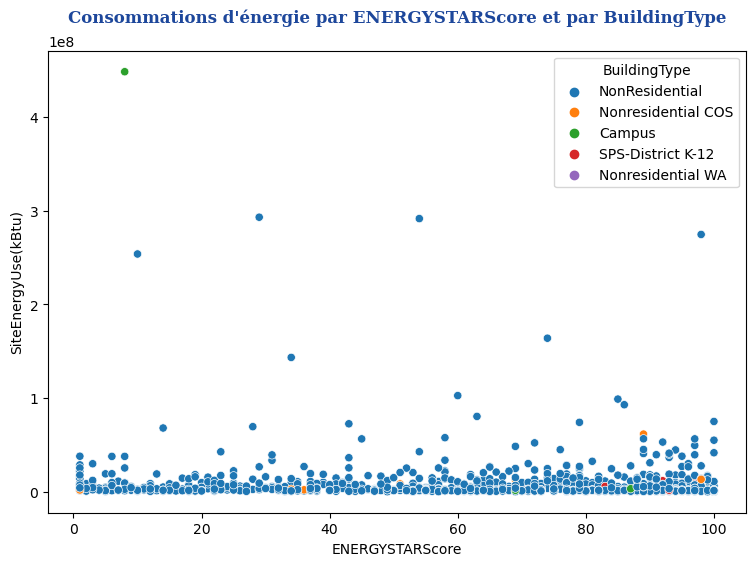

In [123]:
# Nuage de points Consommation d'énergie VS ENERGYSTARScore
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(9,6))
sns.scatterplot(data = dfdata, x='ENERGYSTARScore', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par ENERGYSTARScore et par BuildingType\n", 
          fontdict=font_title, fontsize=12)

On note ici qu'il n'y a pas de corrélation particulière entre ENERGYSTARScore et la consommation d'énergie d'un bâtiment.

### Suppression colonnes inutiles / Définition target / Cleaning

In [124]:
cols_to_drop = ['Unnamed: 0',
                'TotalGHGEmissions']

target = ['SiteEnergyUse(kBtu)']

dfdata.drop(cols_to_drop,axis=1, inplace=True)
dfdata

,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
0,NonResidential,Hotel,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1.0,12,88434,Hotel,60.0,7226362.50,89,0.000000,0.000000,0.000000,0.000000
1,NonResidential,Hotel,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1.0,11,103566,Hotel,61.0,8387933.00,20,0.145453,0.809918,0.145453,0.044629
2,NonResidential,Hotel,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1.0,41,956110,Hotel,43.0,72587024.00,47,0.205748,0.000000,0.000000,0.000000
3,NonResidential,Hotel,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1.0,10,61320,Hotel,56.0,6794584.00,90,0.000000,0.000000,0.000000,0.000000
4,NonResidential,Hotel,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1.0,18,175580,Hotel,75.0,14172606.00,36,0.353115,0.644776,0.355224,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,NonResidential,Small- and Mid-Sized Office,98108.0,2824049007,2,GREATER DUWAMISH,47.53161,-122.29944,1.0,2,24990,Office,9.0,4420650.50,87,0.000000,0.000000,0.000000,0.000000
1519,NonResidential,Other,98155.0,0225049062,4,NORTHEAST,47.68109,-122.26180,1.0,1,72000,Other - Recreation,NaN,2925780.00,3,0.000000,0.000000,0.000000,0.000000
1520,NonResidential,K-12 School,98144.0,7548300840,3,GREATER DUWAMISH,47.58831,-122.30650,1.0,3,45000,K-12 School,77.0,1325972.75,1,0.000000,0.000000,0.000000,0.000000
1521,NonResidential,Mixed Use Property,98109.0,4088803385,7,LAKE UNION,47.62497,-122.33883,1.0,6,345290,Laboratory,NaN,39364116.00,1,0.246251,0.443020,0.311377,0.245603


In [125]:
# Dernier contrôle des valeurs nulles
dfdata[dfdata.isna().any(axis=1)]

,BuildingType,PrimaryPropertyType,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),Age,prop_GFAParking,prop_Use1,prop_Use2,prop_Use3
5,Nonresidential COS,Other,98101.0,0660000560,7,DOWNTOWN,47.61623,-122.33657,1.0,2,97288,Police Station,NaN,1.208662e+07,17,0.382349,0.000000,0.000000,0.000000
7,NonResidential,Other,98101.0,0660000955,7,DOWNTOWN,47.61327,-122.33136,1.0,8,102761,Other - Entertainment/Public Assembly,NaN,6.298132e+06,90,0.000000,0.000000,0.000000,0.000000
14,Nonresidential COS,Other,98154.0,0942000275,7,DOWNTOWN,47.60649,-122.33297,1.0,11,412000,Library,NaN,1.858886e+07,12,0.138350,0.879336,0.118076,0.002588
15,NonResidential,Other,98104.0,0942000350,7,DOWNTOWN,47.60546,-122.33279,1.0,6,103911,Fitness Center/Health Club/Gym,NaN,9.956396e+06,86,0.000000,0.692308,0.307692,0.000000
17,NonResidential,Mixed Use Property,98104.0,0942000510,7,DOWNTOWN,47.60515,-122.33159,1.0,5,57452,Social/Meeting Hall,NaN,7.606084e+06,109,0.000000,0.394406,0.371930,0.233664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,NonResidential,Mixed Use Property,98199.0,2771605298,7,MAGNOLIA / QUEEN ANNE,47.66144,-122.38723,1.0,2,25532,Office,NaN,6.278541e+05,2,0.000000,0.000000,0.000000,0.000000
1513,NonResidential,Other,98134.0,7666203255,2,GREATER DUWAMISH,47.58542,-122.32185,1.0,2,108036,Parking,NaN,4.991894e+06,1,0.000000,0.000000,0.000000,0.000000
1519,NonResidential,Other,98155.0,0225049062,4,NORTHEAST,47.68109,-122.26180,1.0,1,72000,Other - Recreation,NaN,2.925780e+06,3,0.000000,0.000000,0.000000,0.000000
1521,NonResidential,Mixed Use Property,98109.0,4088803385,7,LAKE UNION,47.62497,-122.33883,1.0,6,345290,Laboratory,NaN,3.936412e+07,1,0.246251,0.443020,0.311377,0.245603


Les valeurs nulles restantes sont principalement dans la variable ENERGYSTARScore.  
Dans une première analyse, cette variable sera retirée.  
Dans la seconde partie, nous traiterons ces valeurs nulles.  

#### Etudions le passage de la target y au log :

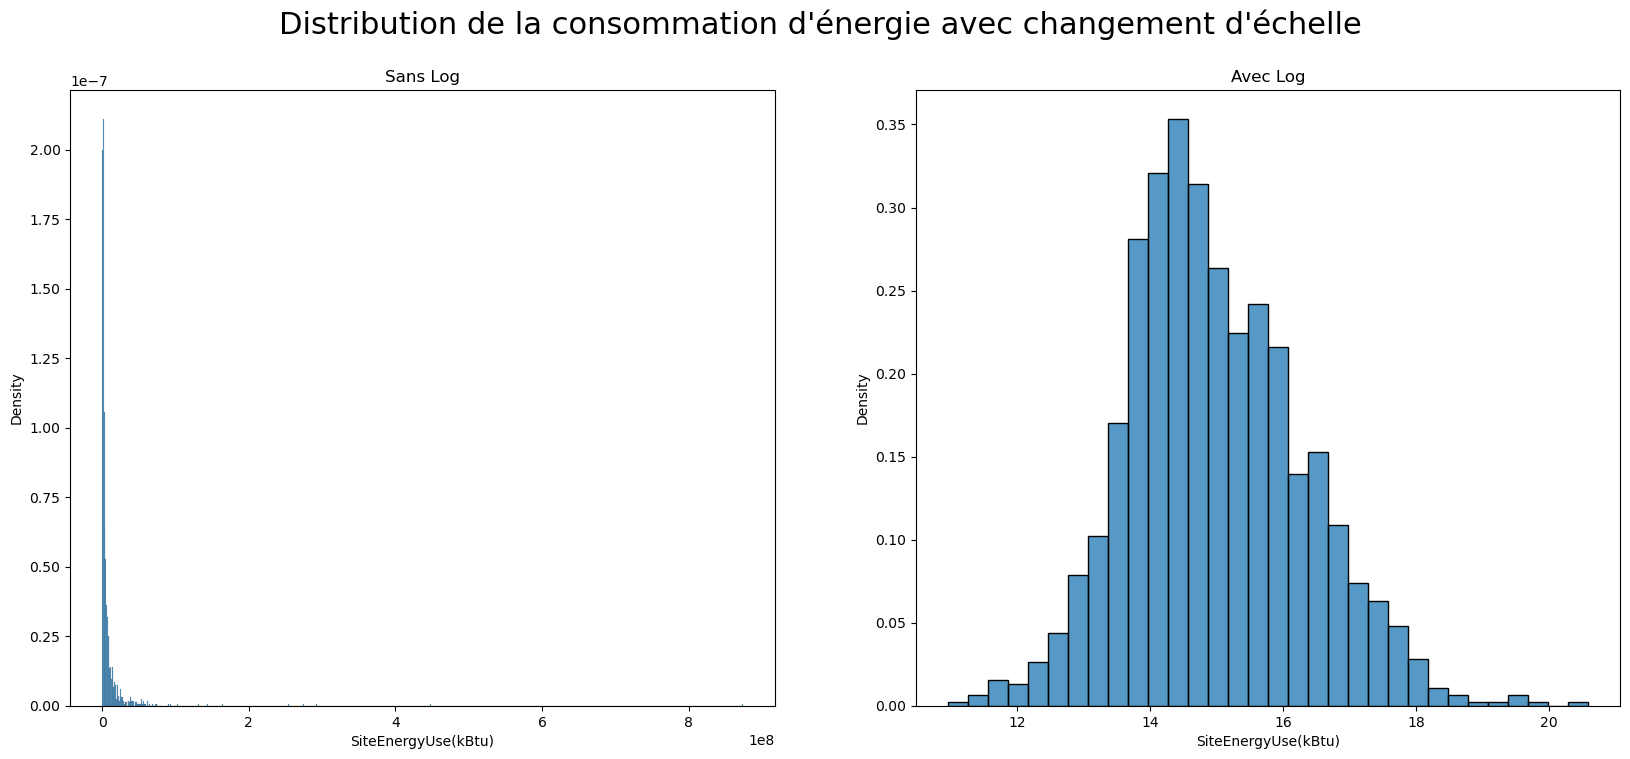

In [126]:
y_col = target
y = dfdata[y_col]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
y_log = logtransformer.transform(y)
X = dfdata.drop(y, axis = 1)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Sans Log")
sns.histplot(data=y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Avec Log")
plt.suptitle("Distribution de la consommation d'énergie avec changement d'échelle", fontsize=22)
plt.show()

#### Format du Dataset de modélisation :

In [127]:
print(" Format de X : {}".format(X.shape))
print(" Format de y : {}".format(y.shape))

 Format de X : (1523, 18)
 Format de y : (1523, 1)


#### Feature engineering (module preprocessing de ScikitLearn) :  
  
    - Variables quantitatives :  
        MinMaxScaler : normalise les données sur une échelle de 0 à 1, sensible aux outliers      
        RobustScaler : normalise les données en fonction des quartiles 1 et 3, peu sensible aux outliers  
        StandardScaler : chaque variable a une moyenne 0 et écart-type 1, sensible aux outliers  
      
    - Variables qualitatives :  
        Encodage One Hot  
            OneHotEncoder : chaque catégorie est représentée de façon binaire dans une colonne propre.     
            TargetEncoder : la probabilité d'occurence de chaque variable dans une seule colonnes.  
        Encodage ordinal  
            LabelEncoder : encodage d'une seule colonne (target), inutilisable ici.      
            OrdinalEncoder : encodage pour plusieurs colonnes, inutilisable ici.

Nous utliserons le MinMaxScaler() pour les variables quantitatives, puis étudierons le OneHotEncoder() et le TargetEncoder() pour les variables qualitatives.

# 1. CONSOMMATION BRUTE - SANS ENERGYSTARSCORE

#### Suppression de la colonne ENERGYSTARScore

In [128]:
X.drop(['ENERGYSTARScore'], axis=1, inplace=True)

#### Définition des groupes de colonnes : quantitatives et qualitatives 

In [129]:
objectColumns = list(X.dtypes[dfdata.dtypes == np.object].index)
numericColumns = list(X.dtypes[dfdata.dtypes != np.object].index)
print("Variables qualitatives :\n {}".format(objectColumns))
print("")
print("Variables quantitatives :\n {}".format(numericColumns))
print("")
print("Target :\n {}".format(list(y.columns)))

Variables qualitatives :
 ['BuildingType', 'PrimaryPropertyType', 'TaxParcelIdentificationNumber', 'Neighborhood', 'LargestPropertyUseType']

Variables quantitatives :
 ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'Age', 'prop_GFAParking', 'prop_Use1', 'prop_Use2', 'prop_Use3']

Target :
 ['SiteEnergyUse(kBtu)']


#### Définition du train_set et du test_set (80 / 20)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

   ## A. MinMaxScaler + OneHotEncoder

#### Preprocessing

In [131]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(OneHotEncoder(handle_unknown = 'ignore'),objectColumns))

#### Modélisation avec pipeline

In [132]:
results = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [133]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults = pd.DataFrame(results, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,7.226397,15.529769,4.272332,-125.633669,0.10
Ridge,0.736996,0.976979,0.543991,0.498825,0.01
Lasso,1.094897,1.380175,0.878949,-0.000202,0.01
ElasticNet,1.094897,1.380175,0.878949,-0.000202,0.01
SVR,0.724230,0.965373,0.553423,0.510661,0.07
RandomForest,0.524378,0.711974,0.387452,0.733837,1.75
XGBoost,0.530723,0.731116,0.381481,0.719333,0.09


#### Crossvalidation

Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

In [20]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [21]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler OneHotEncoder
Best score :  0.7052981846698192
Best parameters :  {'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0, 'randomforestregressor__n_estimators': 500}
score de la prédiction: 0.9609732471959566
RMSE =  0.5244769723858878
MAE =  0.7102050359564054
median abs err =  0.37787534115316745


In [18]:
# Crossvalidation : XGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [19]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler OneHotEncoder
Best score :  0.7184915408328059
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 500}
score de la prédiction: 0.9538189945687061
RMSE =  0.5107459350434466
MAE =  0.7062454973655405
median abs err =  0.35442547702078464


## B. MinMaxScaler + TargetEncoder

#### Preprocessing

In [95]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(TargetEncoder(),objectColumns))

#### Modélisation avec pipeline

In [96]:
results2 = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [97]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results2.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults2 = pd.DataFrame(results2, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults2)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,1.055362,1.327445,0.864950,0.074764,0.03
Ridge,1.036170,1.305189,0.847521,0.105530,0.04
Lasso,1.094897,1.380175,0.878949,-0.000202,0.04
ElasticNet,1.061640,1.344674,0.839239,0.050592,0.04
SVR,0.860144,1.123791,0.661778,0.336882,0.09
RandomForest,1.022152,1.282630,0.839752,0.136183,0.43
XGBoost,1.014770,1.263892,0.875452,0.161237,0.08


#### Crossvalidation

Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

In [98]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [99]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler TargetEncoder
Best score :  0.0797372806678079
Best parameters :  {'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0, 'randomforestregressor__n_estimators': 10}
score de la prédiction: 0.9926545294846862
RMSE =  1.0528644350769103
MAE =  1.3257748931351971
median abs err =  0.8758913468848419


In [100]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [101]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler TargetEncoder
Best score :  0.06628651854735676
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 500}
score de la prédiction: 0.9999786462204694
RMSE =  1.0219740391490273
MAE =  1.2844464523395946
median abs err =  0.8429515289882765


# 2. CONSOMMATION BRUTE - AVEC ENERGYSTARSCORE

#### Imputation de la colonne ENERGYSTARScore pour les valeurs nulles

In [146]:
# Remplissage avec médiane
dfdata['ENERGYSTARScore'] = dfdata['ENERGYSTARScore'].fillna(dfdata['ENERGYSTARScore'].median())

In [147]:
# Nous redéfinissons la dataframe initiale pour la modélisation
y_col = target
y = dfdata[y_col]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
y_log = logtransformer.transform(y)
X = dfdata.drop(y, axis = 1)

#### Définition des groupes de colonnes : quantitatives et qualitatives 

In [148]:
objectColumns = list(X.dtypes[dfdata.dtypes == np.object].index)
numericColumns = list(X.dtypes[dfdata.dtypes != np.object].index)
print("Variables qualitatives :\n {}".format(objectColumns))
print("")
print("Variables quantitatives :\n {}".format(numericColumns))
print("")
print("Target :\n {}".format(list(y.columns)))

Variables qualitatives :
 ['BuildingType', 'PrimaryPropertyType', 'TaxParcelIdentificationNumber', 'Neighborhood', 'LargestPropertyUseType']

Variables quantitatives :
 ['ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore', 'Age', 'prop_GFAParking', 'prop_Use1', 'prop_Use2', 'prop_Use3']

Target :
 ['SiteEnergyUse(kBtu)']


#### Définition du train_set et du test_set (80 / 20)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2)

   ## A. MinMaxScaler + OneHotEncoder

#### Preprocessing

In [150]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(OneHotEncoder(handle_unknown = 'ignore'),objectColumns))

#### Modélisation avec pipeline

In [151]:
results3 = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [152]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results3.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults3 = pd.DataFrame(results3, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults3)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,10.361749,24.266686,5.007654,-308.200494,0.10
Ridge,0.703110,0.942276,0.532376,0.533797,0.01
Lasso,1.094897,1.380175,0.878949,-0.000202,0.01
ElasticNet,1.094897,1.380175,0.878949,-0.000202,0.01
SVR,0.689995,0.936942,0.511880,0.539060,0.07
RandomForest,0.471391,0.661777,0.319227,0.770045,1.81
XGBoost,0.473190,0.671356,0.334653,0.763340,0.09


#### Crossvalidation

Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

In [109]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [110]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler OneHotEncoder
Best score :  0.7372808221923347
Best parameters :  {'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0, 'randomforestregressor__n_estimators': 500}
score de la prédiction: 0.9657391725068708
RMSE =  0.4671961325236197
MAE =  0.6601958570641309
median abs err =  0.3236487283467735


In [111]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [112]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler OneHotEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler OneHotEncoder
Best score :  0.7526461343922524
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 100}
score de la prédiction: 0.9187154172717794
RMSE =  0.4610262321522033
MAE =  0.6630354692746707
median abs err =  0.34035545068486783


#### Feature importance : XGBoost

In [153]:
model = XGBRegressor()
X_ = pd.get_dummies(X, drop_first=True)
col_names = X_.columns
X_ = pd.DataFrame(MinMaxScaler().fit_transform(X_), columns = col_names)
model.fit(X_,y_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

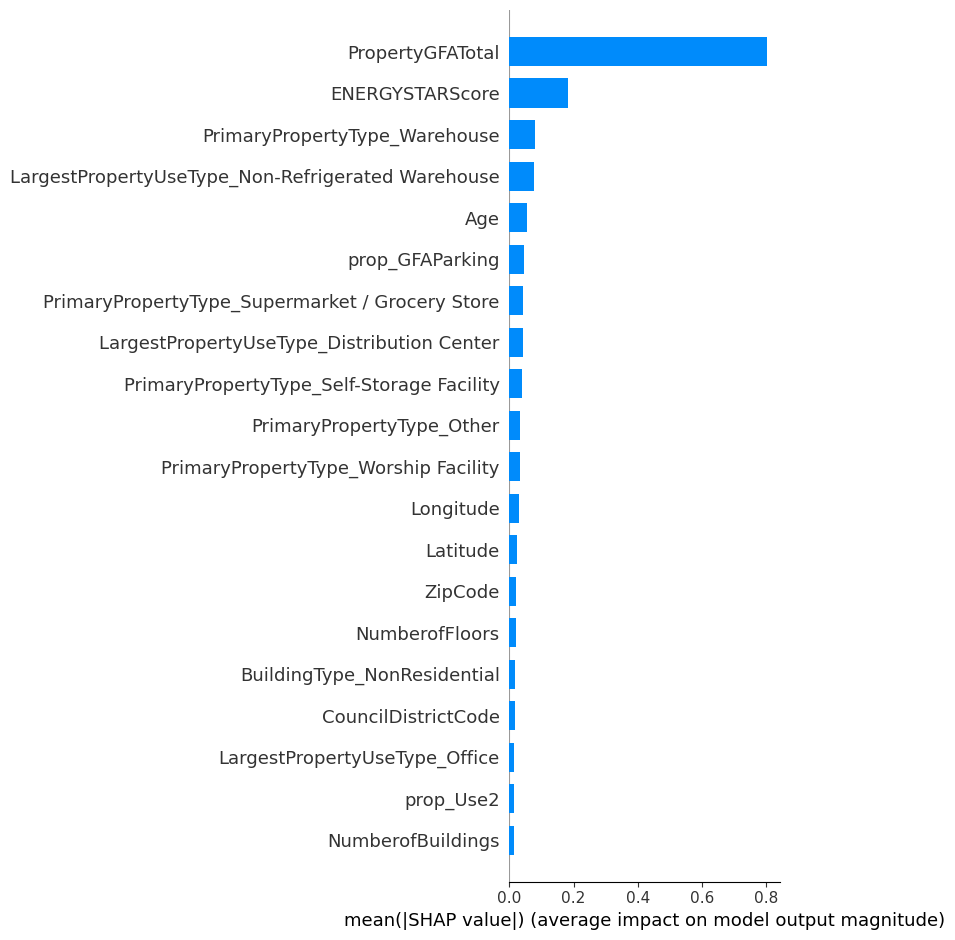

In [154]:
shap_values = shap.TreeExplainer(model).shap_values(X_)
shap.summary_plot(shap_values, X_, plot_type="bar")

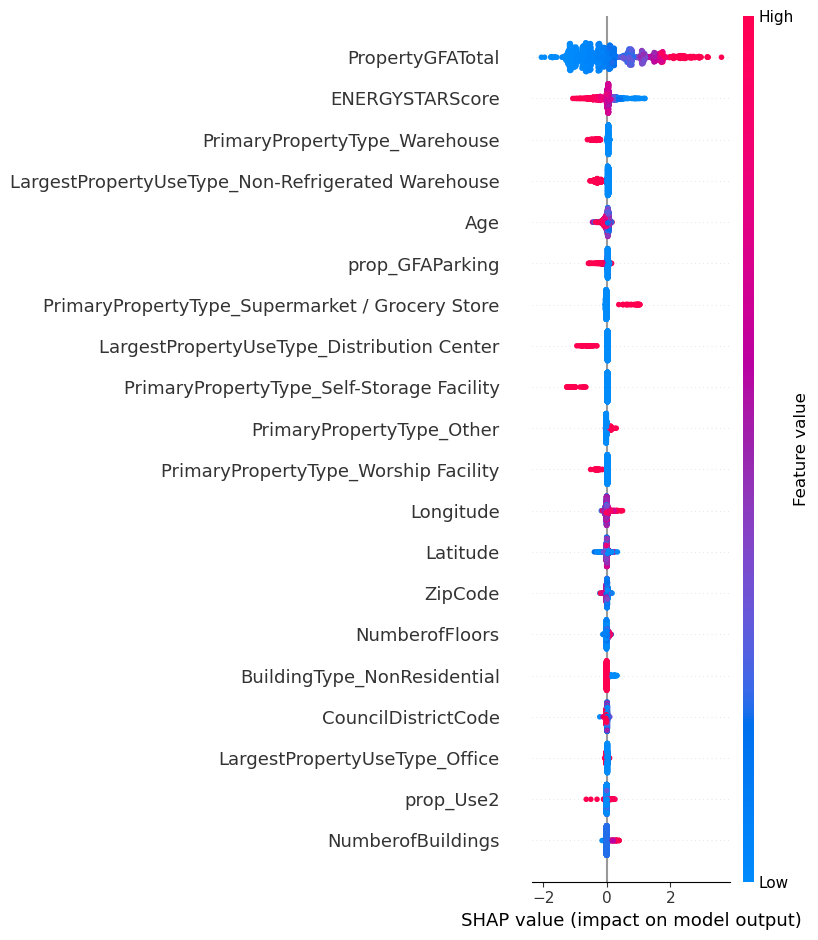

In [155]:
shap.summary_plot(shap_values, X_)

## B. MinMaxScaler + TargetEncoder

#### Preprocessing

In [113]:
preprocessor = make_column_transformer((MinMaxScaler(),numericColumns),(TargetEncoder(),objectColumns))

#### Modélisation avec pipeline

In [114]:
results4 = []
algos = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(tol=0.5),
    'ElasticNet' : ElasticNet(),
    'SVR' : SVR(kernel='rbf'),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
}

X_train, X_test, y_train_all, y_test_all = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [115]:
for algo_name, algo in algos.items():
    start = time.time()
    y_test = y_test_all
    y_train = y_train_all
    model = make_pipeline(preprocessor,algo)
    model.fit(X_train,y_train)
    stop = time.time()
    chrono = round(stop - start,2)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, model.predict(X_test))
    results4.append([mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred), r2, chrono])
    
    
dfresults4 = pd.DataFrame(results4, index =[
    'LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 'RandomForest', 'XGBoost'], 
                         columns =['MAE', 'RMSE', 'Med Abs error', 'R2', 'Chrono (s)'])    
display(dfresults4)

,MAE,RMSE,Med Abs error,R2,Chrono (s)
LinearRegression,1.050278,1.321311,0.854698,0.083295,0.03
Ridge,1.028188,1.295923,0.829971,0.118184,0.04
Lasso,1.094897,1.380175,0.878949,-0.000202,0.03
ElasticNet,1.061640,1.344674,0.839239,0.050592,0.03
SVR,0.851065,1.115789,0.661069,0.346293,0.07
RandomForest,1.044381,1.310889,0.856293,0.097699,0.45
XGBoost,1.027163,1.284907,0.862722,0.133113,0.08


#### Crossvalidation

Selon les résultats de la modélisation ci-dessus, nous n'appliquerons la cross validation que sur les modèles pertinents :  
- RandomForest  
- XGBoost

In [116]:
# Crossvalidation : RandomForest
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [117]:
model = make_pipeline(preprocessor,RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators':[10,100,500], 
    'randomforestregressor__bootstrap':[True,False], 
    'randomforestregressor__ccp_alpha':[0,0.01,0.001]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: RandomForest MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: RandomForest MinMaxScaler TargetEncoder
Best score :  0.08470218879284927
Best parameters :  {'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0, 'randomforestregressor__n_estimators': 10}
score de la prédiction: 0.9942783399846965
RMSE =  0.999728787002375
MAE =  1.2566480204182537
median abs err =  0.8207932948399055


In [118]:
# Crossvalidation : LXGBoostRegressor
XGBRegressor().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_threshold', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [119]:
model = make_pipeline(preprocessor,XGBRegressor())
parameters = {
    'xgbregressor__n_estimators':[10,100,500], 
    'xgbregressor__enable_categorical':[True,False], 
    'xgbregressor__learning_rate':[0.1,0.3,0.5]
}
grid = GridSearchCV(model,parameters, cv=5, n_jobs = 5)
grid.fit(X_train, y_train)
print('Méthode: XGBoost MinMaxScaler TargetEncoder')
print ("Best score : ", grid.best_score_)
print("Best parameters : ",grid.best_params_)
y_pred = grid.predict(X_test)
print("score de la prédiction:", grid.score(X_train, y_train))
print("RMSE = ",mean_absolute_error(y_test,y_pred))
print("MAE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("median abs err = ",median_absolute_error(y_test,y_pred))

Méthode: XGBoost MinMaxScaler TargetEncoder
Best score :  0.08433135395195612
Best parameters :  {'xgbregressor__enable_categorical': False, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 500}
score de la prédiction: 0.9999798517478807
RMSE =  1.0153079651153838
MAE =  1.2742094493587295
median abs err =  0.8530220349595492


# CONCLUSIONS CONCERNANT LES PREDICTIONS DE CONSOMMATION D'ENERGIE

#### ENERGYSTARScore :  
  
La modélisation en incluant cette variable donne de meilleurs résultats : 0.752 VS 0.718 (XGBoostRegressor via GridSearchCV).  En outre, celle-ci apparaît en deuxième position dans la représentation des features importances du modèle, ce qui montre son influence relativement importante sur le modèle.  
  
    
#### Encodage / Transformation :  
  
La méthode d'encodage affichant les meilleurs résultats est le OneHotEncoder couplé au MinMaxScaler.  
  
    
#### Modélisation :  
  
Le modèle affichant les meilleurs résultats est le XGBoostRegressor (best score : 0.752).  
En outre, ce modèle affiche un temps d'entraînement très inférieur au modèle RandomForest ce qui, sur de plus importantes bases de données, aurait une importance significative.      
Mis à part la variable ENERGYSTARScore, les variables ayant le plus d'influence sur notre modèle sont la surface totale, l'âge du bâtiment, le type d'utilisation ou encore la proportion du parking sur l'ensemble de la surface.